# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
#########1#########2#########3#########4#########5#########6#########7#########8
#import generic libraries               
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from time import time
from extract_bottleneck_features import *

#sklearn
from sklearn.datasets import load_files       

#cuda module
#https://pypi.org/project/opencv-python/
import cv2 

#keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

#glob
from glob import glob

#tqm
from tqdm import tqdm

#PIL
from PIL import ImageFile                            

#setting the random seed
random.seed(8675309)

#using matplotlib inline
%matplotlib inline

Using TensorFlow backend.


In [2]:
#########1#########2#########3#########4#########5#########6#########7#########8
# define function to load train, test, and validation datasets
def load_dataset(path):
    '''
    This function loads the dataset containing images and labels.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    Inputs:
    - path (mandatory) - a string containing the path for loading the data
    
    Outputs:
    - dog_files
    - dog_targets
    '''
    data = load_files(path)
    
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)
    
    return dog_files, dog_targets

In [3]:
#########1#########2#########3#########4#########5#########6#########7#########8
start = time()

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = \
[item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

end = time()
print('{:.4f}seconds to process'.format(end-start))

total_dog = len(dog_names)
total_image = len(np.hstack([train_files, valid_files, test_files]))
train_image = len(train_files)
valid_image = len(valid_files)
test_image = len(test_files)

# print statistics about the dataset
print('There are {} total dog categories'.format(total_dog))
print('There are {} total dog images'.format(total_image))
print('-----------------')
print('There are {} training ({:.1f}%) of dog images'\
      .format(train_image, 100 * (train_image/total_image)))
print('There are {} validation ({:.1f}%) of dog images'\
      .format(valid_image, 100 * (valid_image/total_image)))
print('There are {} test ({:.1f}%) of dog images'\
      .format(test_image, 100 * (test_image/total_image)))

0.9619seconds to process
There are 133 total dog categories
There are 8351 total dog images
-----------------
There are 6680 training (80.0%) of dog images
There are 835 validation (10.0%) of dog images
There are 836 test (10.0%) of dog images


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are {} total human images'.format(len(human_files)))

There are 13233 total human images


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


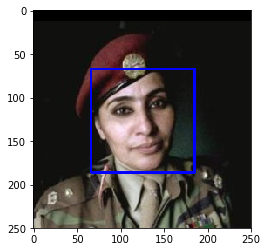

In [5]:
# extract pre-trained face detector
face_cascade = \
cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [6]:
print(img.shape)

(250, 250, 3)


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

---

cv2 is **Open Source Computer Vision** Project and can be find [here](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html)

cv2.imread method at [GeeksforGeeks](https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/)

In [7]:
#########1#########2#########3#########4#########5#########6#########7#########8
def face_detector(img_path,
                  distort=False,
                  decompress=False,
                  verbose=False):
    '''
    This function takes an image path and returns a True, if some face could be
    recognized.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    Inputs:
    - img_path (mandatory) - (Text String)
    - verbose (optional) - if you want some verbosity under processing
      (default=False)
    
    Output:
    - True, is a face was recognized in the image (Boolean)
    '''
    if verbose:
        print('###function face detector started')
        
    start = time()
    classifier='haarcascades/haarcascade_frontalface_alt.xml'
    
    #you take an already trained face detector that is taken from a path
    face_cascade = cv2.CascadeClassifier(classifier)
    
    #originally it is a RGB color image
    img = cv2.imread(img_path) #image as Array
    
    #apply 800x600 lateral compression distortion effect
    if distort:
        if verbose:
            print('*applying (800x600) distortion emulated')
        img = emulate_svga_dist(image=img,
                                as_array=True, #dealing it as Array
                                verbose=verbose)
    #remove 800x600 lateral compression distortion effect
    if decompress:
        if verbose:
            print('*applying (800x600) distortion emulated')
        img = decompress_svga_img(image=img,
                                  as_array=True, #dealing it as Array
                                  verbose=verbose)
    if verbose:
        print('*image:', img_path)
    
    #as we seen in the class, normally human faces were converted to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #run face detector method - for grayscale
    faces = face_cascade.detectMultiScale(gray)
    
    #Test function for faces
    if_face = len(faces) > 0 
    num_faces = len(faces)

    #check if it is OK
    if verbose:
        print('*number of faces detected:{}, returning {}'.format(num_faces, if_face))
        
    end = time()
    
    if verbose:
        print('processing time: {:.4}s'.format(end-start))
    
    return if_face, num_faces

In [8]:
test_face, number = face_detector(
                        img_path=human_files[3],
                        verbose=True)

###function face detector started
*image: ../../../data/lfw/Khatol_Mohammad_Zai/Khatol_Mohammad_Zai_0001.jpg
*number of faces detected:1, returning True
processing time: 0.0451s


### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.
print('first human:', human_files_short[0])
print('first dog:', dog_files_short[0])

first human: ../../../data/lfw/Rick_Dinse/Rick_Dinse_0002.jpg
first dog: ../../../data/dog_images/train/095.Kuvasz/Kuvasz_06442.jpg


Why in an Error, it prints this hellish *oh, no, Captain Goodnight!*?

- its only for a bit of **humor**, there was a game for Apple II named **Captain Goodnight and the Islands of Fear**, wich is now an Abandonware. There was a lot of humor in this game and it provided a lot of fun for me and my friends at my younger age.

- references of the game are at [wiki](https://en.wikipedia.org/wiki/Captain_Goodnight_and_the_Islands_of_Fear), and when something really **weird** happened with your character, this phrase appeard just before you die!

In [10]:
verbose=False

human_errs = []

for human in human_files_short:
    test_face, num_faces = face_detector(
                               img_path=human, 
                               verbose=False)
    
    if test_face and num_faces == 1:
        #print('*all right!')
        pass
    else:
        print('*oh, no, Captain Goodnight!')
        human_errs.append((human, test_face, num_faces))
        
for facerr in human_errs:
    print('{} is a human and was {}, recognized ({} faces)'.format(facerr[0], facerr[1], facerr[2]))

print('total potential mistakes: {}%'.format(len(human_errs)/len(human_files_short) * 100))

*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
../../../data/lfw/Padraig_Harrington/Padraig_Harrington_0002.jpg is a human and was True, recognized (2 faces)
../../../data/lfw/David_Ho/David_Ho_0001.jpg is a human and was True, recognized (2 faces)
../../../data/lfw/Dalai_Lama/Dalai_Lama_0002.jpg is a human and was True, recognized (2 faces)
total potential mistakes: 3.0%


Answer to **Question 1a**:

- well, the number is: **100%** correct, so "everything ran well, and all the humans were correctly interpreted as humans"

- so also we can say: "no **false negatives** (Type II Error) occurred"

- potential troubles could happen with some pictures, that occurred **2 faces** found

  - perhaps we need to **open** these pics as see if there is really more than 1 face in each picture
  
- another potential trouble is that we are testing only a **small part** of our data. So perhaps our **sample** is too small...

- and finally, it also coud occur some **false positives** (Type I Error) with this data. So perhaps a [dragon](https://en.wikipedia.org/wiki/Dragon), or a [Vulcan](https://en.wikipedia.org/wiki/Vulcan_(Star_Trek))  was falsely detected as a **Human** (or, just extrapolating, a **clock** identified as a human face (and a **true** human face not recognized in the same picture!).

In [11]:
verbose=False

dog_errs = []

for dog in dog_files_short:
    test_face, num_faces = face_detector(
                               img_path=dog, 
                               verbose=False)
    
    if test_face: #test for false positives
        print('*oh, no, Captain Goodnight!')
        dog_errs.append((dog, test_face, num_faces))
    
for facerr in dog_errs:
    print('{} is a dog and was {} intepreted as a human ({} faces)'.format(facerr[0], facerr[1], facerr[2]))
    
print('total potential mistakes: {}%'.format(len(dog_errs)/len(dog_files_short) * 100))

*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
*oh, no, Captain Goodnight!
../../../data/dog_images/train/095.Kuvasz/Kuvasz_06442.jpg is a dog and was True intepreted as a human (1 faces)
../../../data/dog_images/train/099.Lhasa_apso/Lhasa_apso_06646.jpg is a dog and was True intepreted as a human (1 faces)
../../../data/dog_images/train/009.American_water_spaniel/American_water_spaniel_00628.jpg is a dog and was True intepreted as a human (1 faces)
../../../data/dog_images/train/057.Dalmatian/Dalmatian_04023.jpg is a dog and was True intepreted as a human (1 faces)
../../../data/dog_images/train/096.Labrador_retriever/Labrador_retriever_06474.jpg is a dog and was True intepreted as a human (1 faces)
../../../data/dog_images/train/106.Newfoundland/Newfoundl

Answer to **Question 1b**:

- well, 11 dogs were incorrectly classified as humans in a sample of 100, so 11% of **error**

- that is a thing to worry about, because they are not just errors. They are Type I errors (**false positives**). And this is normally the **worse** type of error!

- so this Perceptron is not so relliable in terms of **false positives**

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In **Extra Classes** about Perceptrons, we learned at Lesson 3, Class 22/23 that is **not** necessary to be really alligned to be interpreted as True. And this is named **translation invariance**.

So, we could intensely modify the presence algorithm for better recognition of "bad" pictures.

Only on word, somethimes, just saying to the user to stay really **alligned** for the picture is a kind of an invitation to **not stay alligned**! So, people loves to try to break rules, or to cheat an AI (and this is basically the main theme of the movie "The Terminator" (1984).

So if, we could make something just to improve the Accuracy for translated people in a picture, it should be wonderful!

Back into the 22/23 classes, what we can do (and it is not so complicated) is to make **Image Augmentation**. Just take the original dataset and do some artificial translations and retrain it with this new augmented dataset.

**Extra note**: I am not quite sure that we really need to do an Image Augmentation for **translation** in this case. As we already have an algorithm to detect a **face window**, the remaining of the picture will not be interpreted by our Perceptron!

Source: Udacity Extra Classes, Perceptrons, Lesson 3, Class 22/23 (slightly modified, for fitting our new data parameters)

In [12]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

In [13]:
start = time()

#this is a Preprocessing
datagen_train = ImageDataGenerator(
    width_shift_range=0.1, #10 per cent of horizontal
    height_shift_range=0.1, #10 per cent of vertical
    horizontal_flip=False) #it is not in the scope of this exercise

#prepare the AIG
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  #same thing for validation
    height_shift_range=0.1,
    horizontal_flip=True)

# fit both
#datagen_train.fit(x_train)
#datagen_valid.fit(x_valid)

end = time()
print('elapsed time: {:.4f}s'.format(end-start))

elapsed time: 0.0002s


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [14]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

**Numpy Expand** is the inverse of **Numpy Squeeze**. It works as a dimmension expansor for an **Array**. In this case, it is only about modifying the **structure** of our Array. There is no computation process involved (if you thing about Integrates, it is a kind of an **changing of base** (e.g.: goin from 3D to 3D), but in this case, is a more complex process. Documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) 

In [15]:
#########1#########2#########3#########4#########5#########6#########7#########8
def path_to_tensor(img_path,
                   verbose=False):
    '''
    This function takes the path of a image and returns a formatted 4D Tensor.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    Inputs:
    - img_path (mandatory) - (text string)
    - verbose (optional) - if you want some verbosity under processing
      (default=False)

    
    Output:
    A 4-dimensions Tuple, as a Tensor, format (1, 224, 224, 3)
    '''
    if verbose:
        print('###function path to tensor started')

    #RGB image -> PIL.Image.Image
    img = load_img(img_path, 
                   target_size=(224, 224)) #size of the image
    
    #PIL.Image.Image -> 3D tensor dims (224, 224, 3)
    x = img_to_array(img) #3 channels for colors
    
    d4_tensor = np.expand_dims(x, 
                               axis=0) #tensor dims

    return d4_tensor 

**Numpy Vstack** is a kind of a Database opperation from the family of **Concatenate**. The idea is stack vertically (in rows) the vectors. Numpy documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html?highlight=numpy%20vstacks)

In [16]:
#########1#########2#########3#########4#########5#########6#########7#########8
def paths_to_tensor(img_paths,
                    verbose=False):
    '''
    This function takes images paths and returns it as an Array (rows) of
    Tensors for each one.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    Inputs:
    - img_paths (mandatory)
    - verbose (optional) - if you want some verbosity under processing
      (default=False)

    Output:
    - an Array of stacked Tensors, each one as a vector (each vector is a row)
    
    '''
    if verbose:
        print('###function tensors to array started')
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    
    stacked_tensors = np.vstack(list_of_tensors)
    
    return stacked_tensors

Functions for:
    
- load datasets

- test

- validate

**Tensorflow** function **To Categorical** takes an $y$ Array for Categories titles, and the maximum number of classes for training our Perceptron. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) 

In [17]:
#########1#########2#########3#########4#########5#########6#########7#########8
def load_dataset(path, 
                 verbose=False):
    '''
    This function loads datasets. Then it splits filenames into into a dataset
    for training input, and targets into categorical dataset for output for our
    Perceptron.

    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    Inputs:
    - path (mandatory) - a path for taking a picture - (text string)
    - verbose (optional) - if you want some verbosity under processing
      (default=False)

    
    Output:
    - dog_files
    - dog_targets
    '''
    if verbose:
        print('###function load dataset started')
    
    data = load_files(path)
    
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(y=np.array(data['target']), 
                                 num_classes=133)
    
    return dog_files, dog_targets

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function 

`preprocess_input`  

If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

**Numpy** function **Argmax** takes an Axis (a Vector) and returns the index for the argument with the maximum value. Documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html?highlight=argmax#numpy.argmax)

In [18]:
#########1#########2#########3#########4#########5#########6#########7#########8
def ResNet50_predict_labels(img_path,
                            distort=False,
                            decompress=False,
                            verbose=False):
    '''
    This function takes an image from a path and runs ResNet50 model to make a
    prediction and returns the index for the best argument.

    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!

    Inputs:
    - img_path
    - verbose (optional) - if you want some verbosity under processing
      (default=False)

    Output:
    - an Index for the best prediction of an image
    '''
    if verbose:
        print('###function ResNet 50 predictions started')
        
    start = time()

    #creates a prediction for a given image, located in a path
    #OLD way:
    #img = preprocess_input(path_to_tensor(img_path))

    img = load_img(img_path, 
                   target_size=(224, 224))

    if distort:
        if verbose:
            print('*applying (800x600) distortion emulated')
        #creating a distorted image (needs the function below in this notebook)    
        img = emulate_svga_dist(image=img,
                                verbose=True)
        
    #remove 800x600 lateral compression distortion effect
    if decompress:
        if verbose:
            print('*applying (800x600) distortion emulated')
        #creating a distorted image (needs the function below in this notebook)
        img = decompress_svga_img(image=img,
                                  verbose=verbose)

        
    x = img_to_array(img) #3 channels for colors    
    d4_tensor = np.expand_dims(x, 
                               axis=0) #tensor dims
    if verbose:
        print('*creating a Tensor from image, with shape:', d4_tensor.shape)
        
    prediction = np.argmax(ResNet50_model.predict(d4_tensor))
    
    end = time()
    
    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))
    
    return prediction

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [19]:
#########1#########2#########3#########4#########5#########6#########7#########8
def dog_detector(img_path,
                 distort=False,
                 decompress=False,
                 verbose=False):
    '''
    This function returns a True when a dog is detected.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    Inputs:
    - img_path
    - verbose (optional) - if you want some verbosity under processing
      (default=False)
    
    Output:
    - True, if a dog was detected, False else
    '''
    if verbose:
        print('###function dog detector started')
        
    start = time()
    
    if verbose:
        print('*image:', img_path)
        
    prediction = ResNet50_predict_labels(img_path,
                                         distort=distort,
                                         decompress=decompress)
    
    if_prediction = ((prediction <= 268) & (prediction >= 151)) 
    
    if verbose:
        print('*if a dog was detect: {}'.format(if_prediction))
        
    end = time()
    
    if verbose:
        print('processing time: {:.4}s'.format(end-start))
    
    return if_prediction

### Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__

Now it hs time to test the performance of our **dog detector function**. We will use the images from:

- human_files_short

- dog_files_short

In [20]:
start = time()

num_human = 0

for human in human_files_short:
    if dog_detector(human):
        num_human += 1
        
print("at the human file, {} humans were recognized as a dog!"\
      .format(num_human))

end = time()

print('elapsed time: {:.4f}s'.format(end-start))

at the human file, 0 humans were recognized as a dog!
elapsed time: 4.1711s


In [21]:
start = time()

num_dog = 0

for dog in dog_files_short:
    if dog_detector(dog):
        num_dog += 1
        
print("at the dog file, {} dogs were recognized as a dog!"\
      .format(num_dog))

end = time()

print('elapsed time: {:.4f}s'.format(end-start))

at the dog file, 91 dogs were recognized as a dog!
elapsed time: 3.9767s


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [22]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 104.72it/s]


### Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

OK, it´s fine to see the **right graph** about this CNN architecture.

- I can see an **Input** layer ...

- ... then 3x **Convolutional + Pooling** layers ...

- ... then a **Dense** layer ...

- finally a **Output** layer

But, what´s the hell this **GAP** layer between the **Convolution** part and the **Dense** part of the Perceptron?

- asking **Google** I could retrieve that this is a **Global Average Pooling** layer, and that was proved to be a good **regularizer** for CNNs

- it works as a **Pooling Layer**, but more radically reducing $h \times w \times d$ Tensors, to a $1 \times 1 \times d$ Vector

- it makes sense for me, as we need the **Output** from a Perceptron to be something like a **Vector**

First time I tried, I had the error:

`ValueError: Error when checking target: expected dense_1 to have 4 dimensions, but got array with shape (6680, 133)`

And... it is a bit **hard** to put everything in practic!

- run time: 572s

- test Accuracy: 0.9569%

- epochs: 30

In [23]:
#this is my first functional model
model = Sequential()

#first Conv layer <-input as an 3D Array 224x224x3
model.add(Conv2D(filters=32, #perhaps 16, 46
                 kernel_size=4, #2, 8
                 activation='relu', #I guess it is a good one!
                 input_shape=(224, 224, 3) #I need this in my first layer
))
model.add(MaxPooling2D(pool_size=4)) #2, 8

#second Conv Layer
model.add(Conv2D(filters=64,
                 kernel_size=4, 
                 activation='relu'
))
model.add(MaxPooling2D(pool_size=4))

#third Conv Layer
model.add(Conv2D(filters=128, #128 complex filters?
                 kernel_size=4, 
                 activation='relu'
))
model.add(MaxPooling2D(pool_size=4))

#GAP Layer
model.add(GlobalAveragePooling2D()) #my strange GAP pooling

#Dense Layer -> Output as a Vector
model.add(Dense(133, 
                activation='sigmoid' #or'softmax'?
))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 221, 221, 32)      1568      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       131200    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
__________

With dropout:

- reviewing my classes notes, I start planning to use **Dropout**

- I also changed my **Activation Function** from **Sigmoid** to **Softmax**

- I tought to add a **second** dense layer at the end, but started to be afraid of exausting my **GPU** use time

- test accuracy: 15.3110%

In [24]:
model = Sequential()

##first Conv layer <-input as an 3D Array 224x224x3
model.add(Conv2D(filters=32, #16
                 kernel_size=4, #2
                 activation='relu', 
                 input_shape=(224, 224, 3) #I need this in my first layer
))
model.add(MaxPooling2D(pool_size=2)) #2
model.add(Dropout(0.2)) #.5

##second Conv layer
model.add(Conv2D(filters=64, 
                 kernel_size=4, 
                 activation='relu'
))
model.add(MaxPooling2D(pool_size=2)) #2
model.add(Dropout(0.2)) #.5

##third Conv Layer
model.add(Conv2D(filters=128, 
                 kernel_size=4, 
                 activation='relu'
))
model.add(MaxPooling2D(pool_size=2)) #2
model.add(Dropout(0.2)) #.5

#GAP layer
model.add(GlobalAveragePooling2D())

#Dense Layer -> Output as a Vector
model.add(Dense(133, 
                activation='softmax'
))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 221, 221, 32)      1568      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 107, 107, 64)      32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 128)       131200    
__________

### Compile the Model

In [25]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement.

Now it is time to specify the Epochs to train

First I specify 50 Epochs to train

- it takes **so long** that I feel that I need to **reduce** it (kind of a **dozen** Epochs?)

Second, I felt that 12 epochs are a too low number

- kind of **two dozens** is enough?

- well, I think it is **not**! Let´s try, I don´t know... 30 Epochs?

In [26]:
epochs = 20 #30 #50 #12

start = time()

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

end = time()

print('elapsed time: {:.4f}s'.format(end-start))

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 44s 7ms/step - loss: 4.8669 - acc: 0.0141 - val_loss: 4.8160 - val_acc: 0.0156
Epoch 2/20
6680/6680 [==============================] - 43s 6ms/step - loss: 4.8023 - acc: 0.0174 - val_loss: 4.7879 - val_acc: 0.0216
Epoch 3/20
6680/6680 [==============================] - 43s 6ms/step - loss: 4.7469 - acc: 0.0232 - val_loss: 4.7124 - val_acc: 0.0311
Epoch 4/20
6680/6680 [==============================] - 43s 6ms/step - loss: 4.6701 - acc: 0.0320 - val_loss: 4.6946 - val_acc: 0.0455
Epoch 5/20
6680/6680 [==============================] - 43s 6ms/step - loss: 4.5955 - acc: 0.0382 - val_loss: 4.5806 - val_acc: 0.0347
Epoch 6/20
6680/6680 [==============================] - 43s 6ms/step - loss: 4.5026 - acc: 0.0491 - val_loss: 4.5016 - val_acc: 0.0431
Epoch 7/20
6680/6680 [==============================] - 43s 6ms/step - loss: 4.4222 - acc: 0.0530 - val_loss: 4.4425 - val_acc: 0.0575
Epoch 8/

### Load the Model with the Best Validation Loss

In [27]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [28]:
#using arbax to retrieving the index for the best dog breed predicted
dog_breed_predictions = \
[np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

#testing the accuracy of the model
test_accuracy = \
100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)

print('Test accuracy: {:.4f}'.format(test_accuracy))

Test accuracy: 14.1148


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [29]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')

train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [30]:
VGG16_model = Sequential()

VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, 
                      activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [31]:
VGG16_model.compile(loss='categorical_crossentropy', 
                    optimizer='rmsprop', 
                    metrics=['accuracy'])

### Train the Model

In [32]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
                validation_data=(valid_VGG16, valid_targets),
                epochs=20, 
                batch_size=20, 
                callbacks=[checkpointer], 
                verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 292us/step - loss: 12.0789 - acc: 0.1271 - val_loss: 10.3706 - val_acc: 0.2335
Epoch 2/20
6680/6680 [==============================] - 2s 251us/step - loss: 9.6862 - acc: 0.3001 - val_loss: 9.4811 - val_acc: 0.3090
Epoch 3/20
6680/6680 [==============================] - 2s 251us/step - loss: 9.0743 - acc: 0.3648 - val_loss: 9.3897 - val_acc: 0.3377
Epoch 4/20
6680/6680 [==============================] - 2s 251us/step - loss: 8.7691 - acc: 0.4009 - val_loss: 9.1620 - val_acc: 0.3449
Epoch 5/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.4209 - acc: 0.4274 - val_loss: 8.7719 - val_acc: 0.3665
Epoch 6/20
6680/6680 [==============================] - 2s 252us/step - loss: 8.1925 - acc: 0.4542 - val_loss: 8.6953 - val_acc: 0.3868
Epoch 7/20
6680/6680 [==============================] - 2s 255us/step - loss: 7.9800 - acc: 0.4728 - val_loss: 8.4990 - val_acc: 0.4000

### Load the Model with the Best Validation Loss

In [33]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

- test Accuracy: is near to 40%

*Commentary: using pre-trained layers improved a lot the model Accuracy*

In [34]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = \
[np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = \
100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)

print('Test accuracy: {:.4f}'.format(test_accuracy))

Test accuracy: 46.4115


### Predict Dog Breed with the Model

In [35]:
#########1#########2#########3#########4#########5#########6#########7#########8
def VGG16_predict_breed(img_path,
                        verbose=False):
    '''
    This function kahes an image path, process it under VGG16 and return a guess
    for the dog breed.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!

    Inputs:
    - img_path
    - verbose (optional) - if you want some verbosity under processing
      (default=False)
    
    Output:
    - a string containing a predicted name for a dog breed
    '''
    if verbose:
        print('###function VGG16 predict breed started')
        
    start = time()
    
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    predicted_name = dog_names[np.argmax(predicted_vector)]
    
    end = time()

    print('elapsed time: {:.4f}s'.format(end-start))
    
    return predicted_name

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

My original idea was to directly download all these Bottlenecks into Udacity workspace:

In [36]:
#import requests

#VGG-19
#link1 = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz'
#ResNet-50
#link2 = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz'
#Inception
#link3 = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz'
#Xception
#link4 = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz'

#urllib.request.urlretrieve(link1)

But then some strange things happened. And then I reallized that I don´t have enough space on my workspace drive to put them all...

In [37]:
#my first dictionnary conception
'''
b_necks = {'VGG19': 'bottleneck_features/DogVGG19Data.npz',
           'Resnet50': 'bottleneck_features/DogResnet50Data.npz',
           'InceptionV3': 'bottleneck_features/DogInceptionV3Data.npz',
           'DogXception': 'bottleneck_features/DogXceptionData.npz'
}
'''
#short version, with only two bottlenecks
b_necks = {'Resnet50': 'bottleneck_features/DogResnet50Data.npz',
           'InceptionV3': 'bottleneck_features/DogInceptionV3Data.npz'
}

In [38]:
#short version, with only two bottlenecks
b_neck = {
    'Resnet50': 'bottleneck_features/DogResnet50Data.npz',
    'InceptionV3': 'bottleneck_features/DogInceptionV3Data.npz'
}

#NEXT STEPS, NOT YET IMPLEMENTED!
#long version, for Version 2 of the charge_bottlenecks function
'''
b_neck = {'Resnet50': {'link': 'bottleneck_features/DogResnet50Data.npz',
                       'filters': 32, #32,64 Conv layer
                       'kernel': 4, #2,4 conv
                       'activation': 'relu',
                       'strides': 2, #2,3 conv
                       'padding': 'same', #'same','valid' valid conv
                       'pool': 4, #2,4 MaxP layer
                       'padding_max': 'same',
                       'activation_end': 'softmax'}, #'softmax', 'sigmoid' End layer

          'Inceptionv3': {'link': 'bottleneck_features/DogInceptionV3Data.npz',
                          'filters': 32,
                          'kernel': 4,
                          'activation': 'relu',
                          'strides': 2,
                          'padding': 'same',
                          'pool': 4,
                          'padding_max': 'same',
                          'activation_end': 'softmax'},
}
'''
print()

The idea is quite simple:
    
1. create a basic **dictionnary** structure to iterate with Bottlenecks, passing parameters and evaluating them for **Accuracy**

2. evolve a function for passing all the parameters for iterating and testing all the steps of turning **Bottlenecks** into **Complete Perceptrons**

3. train and evaluate them, with some **general parameters** and then finally, evolve our function to test a bunch of **alternative parameters**, some comming from my new (future) enhanced dictionnary, and others from my function call

---

**DON´t use this one!**

I commit a conceptual mistake:

- my idea was to create inside a function customized calls, using **exec()** command;

- the problem is, this creates calls in a **virtual** python machine, and the objects cannot be called back;

- so, when I need to call `Resnet50_predictions = [np.argmax(Resnet50_model.predict(...` it returns me the error that `NameError: name 'Resnet50_model' is not defined`;

- sure, in fact it does **not** exist!

So, please, pass this one and take the other one, with the same name.

In [39]:
#########1#########2#########3#########4#########5#########6#########7#########8
'''
def charge_bottlenecks(dic_bottles, 
                       split=False, 
                       architecture=False, #arch part
                       filters=32, #arch
                       kernel=4, #arch
                       activation='relu', #arch
                       activation_end='softmax', #arch
                       padding='same', #arch
                       padding_max='same', #arch
                       model_compile=False, #comp part
                       loss_function='categorical_crossentropy', #comp
                       optimizer='rmsprop', #comp
                       summary=False, #comp
                       train=False,
                       epochs=20,
                       batch_size=20,
                       load=False,
                       test=False,
                       giving='accuracies'):
                       
    print('###DISCONTINUED FUNCTION')
        
    start = time()
    
    ls_accuracies = []
    
    for name, link in dic_bottles.items():
        #print(name, link)
        print('{}, preparing charge...'.format(name))
        comm1 = 'b_neck_' + name + ' = np.load("' + link + '")'
        print(' ', comm1)
        exec(comm1)
        print()
        
        if split:
            print('*splitting the data')
            comm2 = 'train_' + name + ' = b_neck_' + name + '["train"]'
            print(' ', comm2)
            exec(comm2)
            comm3 = 'valid_' + name + ' = b_neck_' + name + '["valid"]'
            print(' ', comm3)
            exec(comm3)
            comm4 = 'test_' + name + ' = b_neck_' + name + '["test"]'
            print(' ', comm4)
            exec(comm4)
            print()
    
        if architecture:
            print('*defining the architecture')
            comm5 = name + '_model = Sequential()'
            print(' ', comm5)
            exec(comm5)
            comm6 = name + '_model.add(Conv2D(filters=' + str(filters) + \
                    ', kernel_size=' + str(kernel) + ', activation= "' + activation + '"' +\
                    ', padding="'+ padding + '", input_shape=train_' + name + '.shape[1:]))'
            print(' ', comm6)
            exec(comm6) 
            comm7 = name + '_model.add(MaxPooling2D(pool_size=2,padding="' + padding + '"))' 
            print(' ', comm7)
            exec(comm7)
            comm8 = name + '_model.add(GlobalAveragePooling2D())' #GAP layer added!
            print(' ', comm8)
            exec(comm8)
            comm9 = name + '_model.add(Dense(133, activation="' + activation_end + '"))'
            print(' ', comm9)
            exec(comm9)            
            if summary:
                comm9b = name + '_model.summary()'
                print(' ', comm9b)
                exec(comm9b)
            print()

        if model_compile:
            print('*compiling the model')
            comm10 = name + '_model.compile(loss="' + loss_function + '"' +\
                     ', optimizer="' + optimizer + '", metrics=["accuracy"])'
            print(' ', comm10)
            exec(comm10)
            print()
            
        if train:
            print('*training the model')
            filepath = 'saved_models/weights.best.' + name + '.hdf5'
            comm11 = 'check = ModelCheckpoint(filepath="' + filepath + '"' +\
                     ', verbose=1, save_best_only=True)'
            print(' ', comm11)
            exec(comm11)
            comm11b = name + '_model.fit(train_' + name + ', train_targets, ' +\
                      'validation_data=(valid_' + name + ', valid_targets), ' +\
                      'epochs=' + str(epochs) + ', batch_size='+ str(batch_size) +\
                      ', callbacks=[check], verbose=1)'
            print(' ', comm11b)
            exec(comm11b)
            print()
            
        if load:
            print('*loading the model')
            comm12 = name + '_model.load_weights("' + filepath + '")'
            print(' ', comm12)
            exec(comm12)
            print()
            
        exec('modelx = 50')
            
        return modelx
            
        if test:
            print('*testing the model')
            
            #first taking the best prediction
            comm13m = name + ''
            comm13 = name + '_predictions = [np.argmax(' + name +\
            '_model.predict(np.expand_dims(feature, axis=0))) for feature in test_' + name + ']'
            print(' ', comm13)
            exec(comm13)
            
            #Resnet50_predictions = 
            
            #second testing for its Accuracy
            comm13b = 'test_accuracy = 100*np.sum(np.array(' + name +\
            '_predictions)==np.argmax(test_targets, axis=1))/len(' + name + '_predictions)'
            print(' ', comm13b)
            exec(comm13b)
            print('Test accuracy: {.4f}'.format(test_accuracy))
            
            ls_accuracies.append((name, test_accuracy))
            
        end = time()

        print('elapsed time: {:.4f}s'.format(end-start))
            
        if giving == 'accuracies':
            return ls_accuracies
'''
print()

In [40]:
#########1#########2#########3#########4#########5#########6#########7#########8
def charge_bottlenecks(dic_bottles, 
                       split=False, 
                       architecture=False,
                       filters=32, #arch
                       kernel=4, #arch
                       activation='relu', #arch
                       activation_end='softmax', #arch
                       strides=2, #arch
                       pool=4, #arch
                       padding='same', #arch
                       padding_max='same', #arch
                       model_compile=False,
                       loss_function='categorical_crossentropy', #comp
                       optimizer='rmsprop', #comp
                       summary=False, #comp
                       train=False,
                       epochs=20, #train
                       batch_size=20, #train
                       load=False,
                       test=False,
                       giving='accuracies'):
    '''
    This function takes one or more bottletecks and prepare a complete running.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    It includes:
    0. obtaining the Bottleneck to be completed and runned;
    1. a data split, into Train, Valid and Test datasets;
    2. de definition of the architecture, meaning the completion of the 
       Bottleneck with the necessary final (Dense) layers to run it;
    3. compiling the Model (incluiding an optional Summary visualization);
    4. training the Model;
    5. loading the best trained Model;
    6. testing the model for Accuracy.
    
    Observe that:
    - each step is strongly dependant of the last one. So, you can make only a
      Split, but for doing for example, defining an Architecture, Split will be
      necessary. So, BEFORE turning all these steps True, ensure that the anterior
      steps are are running well. Use it WISELY, or it will crash!
    
    Inputs:
    - dic_bottles (mandatory) - dictionnary with the name of the selected 
      Bottlenecs, with the path for each one - (Dictionnary)
    - split (optional) - add Split phase - (Boolean, default=False)
    - architecture (optional) - add Architecture phase - (Boolean, default=False)
    - filters (optional) - filters for the Dense layer - (Integer, default=32)
    - kernel (optional) - (Boolean, default=4)
    - activation (optional) - (Boolean, default='relu') - activation function
      for the Dense layer (String, default='relu')
    - activation_end (optional) - activation function at the END of the
      Perceptron (String, default='softmax') 
    - padding (optional) - padding option - (Boolean, default='same')
    - model_compile (optional) - add Compile phase - (String, default=False)
    - loss_function (optional) - (Boolean, default='')
    - summary (optional) - add Summary phase - (Boolean, default=False)
    - train (optional) - add Train phase - (Boolean, default=False)
    - epochs (optional) - number of epochs - (Integer, default=20)
    - batch_size (optional) - batches for alleviating the algorithm -
      (Integer, default=20)
    - load (optional) - add Load phase - (Boolean, default=False)
    - test (optional) - add Test phase - (Boolean, default=False)
    - giving (optional) - (String, default='accuracies')
    '''
    print('###function charge bottlekecks started')
        
    start = time()
    
    ls_accuracies = []
    
    for name, link in dic_bottles.items():
        #print(name, link)
        print('{}, preparing charge...'.format(name))
        b_neck_dogb = np.load(link)
        
        if split:
            print('*splitting the data')
            train_dogb = b_neck_dogb["train"]
            valid_dogb = b_neck_dogb["valid"]
            test_dogb = b_neck_dogb["test"]
    
        if architecture:
            print('*defining the architecture')
            dogb_model = Sequential()
            dogb_model.add(Conv2D(filters=filters, 
                                  kernel_size=kernel, 
                                  activation=activation,
                                  strides=strides,
                                  padding=padding, 
                                  input_shape=train_dogb.shape[1:]))
            dogb_model.add(MaxPooling2D(pool_size=pool,
                                        padding=padding_max)) 
            dogb_model.add(GlobalAveragePooling2D()) #GAP layer added!
            dogb_model.add(Dense(133, 
                                 activation=activation_end))                  
            if summary:
                dogb_model.summary()

        if model_compile:
            print('*compiling the model')
            dogb_model.compile(loss=loss_function,
                               optimizer=optimizer,
                               metrics=["accuracy"])            
        if train:
            print('*training the model')
            filepath = 'saved_models/weights.best.dogb.hdf5'
            check = ModelCheckpoint(filepath=filepath, 
                                    verbose=1, 
                                    save_best_only=True)
            dogb_model.fit(train_dogb,
                           train_targets,
                           validation_data=(valid_dogb, valid_targets),
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=[check],
                           verbose=1)
            
        if load:
            print('*loading the model')
            dogb_model.load_weights(filepath)
                        
        if test:
            print('*testing the model')
            #first, taking the best prediction
            
            dogb_pred = []
            
            for feature in test_dogb:
                feat_pred = dogb_model.predict(np.expand_dims(feature, axis=0))
                best_pred = np.argmax(feat_pred)
                dogb_pred.append(best_pred)
            
            #second, testing for its Accuracy
            filter_cont = np.array(dogb_pred)==np.argmax(test_targets, axis=1)
            test_accuracy = 100 * (np.sum(filter_cont) / len(dogb_pred))
            print('Test accuracy: {:.4f}'.format(test_accuracy))
            
            ls_accuracies.append((name, test_accuracy))
            
    end = time()

    print('elapsed time: {:.4f}s'.format(end-start))
            
    if giving == 'accuracies':
        return ls_accuracies

---

### A slight note about of what we are doing here

#### First Phase:

- the idea is to gradually **evolve** a `charging_bottleneks` function;

- in this phase of the process, the parameters values are a bit **arbitrary**;

- the idea is to capture all the **parameters** that could be passed to our model by a main function;

#### Second Phase:

- I will create a **dictionnary** with some **customized values** to be passed to our model;

- so, I can test a **lot** of parameters in an automatized way;

- making a general calling in the **main** function, or enhancing these values in a **dictionnary**

---

### Loading Bottleneck

**Step1** Obtaining bottleneck features (pre-trained firsts layers)

- from pre-trained CNNs

*Why it is returning an **empty list**? The idea is when everything was OK, it will give us **precious parameters** for each trying for training a CNN, including Accuracy for each one*

In [41]:
b_neck = {'Resnet50': 'bottleneck_features/DogResnet50Data.npz',
}

charge_bottlenecks(
    dic_bottles=b_neck
)

###function charge bottlekecks started
Resnet50, preparing charge...
elapsed time: 0.0018s


[]

### Splitting Data

**Step 2** Bottleneck features + split data

- this `split` is about data already splitted!

*Everything going so well!*

In [42]:
charge_bottlenecks(
    dic_bottles=b_neck, 
    split=True
)

###function charge bottlekecks started
Resnet50, preparing charge...
*splitting the data
elapsed time: 0.1861s


[]

### Defining an Architecture

**Step 3** Bottleneck features + split data + model architecture (add final layers)

**Oh, no, Captain Goodnight!**

`Resnet50` gave the error:

`ValueError: Negative dimension size caused by subtracting 4 from 1 for 'conv2d_1/convolution' (op: 'Conv2D') with input shapes: [?,1,1,2048], [4,4,2048,32].` $\rightarrow$ what caused the error was `padding` argument

Problem solved, let me see:

In [43]:
charge_bottlenecks(
    dic_bottles=b_neck, 
    split=True, 
    architecture=True,
    filters=64,
    kernel=2,
    activation='relu',
    activation_end='softmax',
    pool=2, 
    padding='same',
)

###function charge bottlekecks started
Resnet50, preparing charge...
*splitting the data
*defining the architecture
elapsed time: 0.2008s


[]

### Compiling

**Step 4** Bottleneck features + split data + defining an architecture + compiling

**Oh, no, Captain Goodnight!**

`Resnet50` gave the error:

Gave the error: `ValueError: Input 0 is incompatible with layer max_pooling2d_7: expected ndim=4, found ndim=2` $\leftarrow$ Oh, I forgot to add a `Dense` layer at the end, just to taking a vector as Output!

*Problem solved...*

In [44]:
charge_bottlenecks(
    dic_bottles=b_neck, 
    split=True, 
    architecture=True,
    filters=32,
    kernel=4,
    activation='relu',
    activation_end='softmax',
    pool=4, 
    padding='same',
    model_compile=True,
    loss_function='categorical_crossentropy',
    optimizer='rmsprop',
    summary=True
)

###function charge bottlekecks started
Resnet50, preparing charge...
*splitting the data
*defining the architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1, 1, 32)          1048608   
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               4389      
Total params: 1,052,997
Trainable params: 1,052,997
Non-trainable params: 0
_________________________________________________________________
*compiling the model
elapsed time: 0.2360s


[]

### Training

**Step 5** Bottleneck features + split data + defining an architecture + compiling + training

**Oh, no, Captain Goodnight!**

`ResNet50` gave the error:

`NameError: name 'saved_models' is not defined` $\leftarrow$ only a easy-to-solve problem!

`NameError: name 'checkpointer' is not defined`$\leftarrow$ another minor problem!

*Why only **5** Epochs? Just because we are just **evolving** our function, so the result is not important for now!*

*Everything corrected, and...*

In [45]:
charge_bottlenecks(
    dic_bottles=b_neck, 
    split=True, 
    architecture=True,
    filters=32,
    kernel=4,
    activation='relu',
    activation_end='softmax',
    pool=4, 
    padding='same',
    model_compile=True,
    loss_function='categorical_crossentropy',
    optimizer='rmsprop',
    summary=True,
    train=True,
    epochs=5,
    batch_size=20
)

###function charge bottlekecks started
Resnet50, preparing charge...
*splitting the data
*defining the architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 1, 1, 32)          1048608   
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               4389      
Total params: 1,052,997
Trainable params: 1,052,997
Non-trainable params: 0
_________________________________________________________________
*compiling the model
*training the model
Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 5s 70

[]

### Loading the Model with the Best Validation Loss

**Step 5** Bottleneck features + split data + defining an architecture + compiling + training + loading

**Oh, no, Captain Goodnight!**

`Resnet50` Gave the error message:
    
`OSError: Unable to open file (unable to open file: name = 'saved_models/weights.best.Resnet50.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)` $\leftarrow$ another minor problem solved!

In [46]:
charge_bottlenecks(
    dic_bottles=b_neck, 
    split=True, 
    architecture=True,
    filters=64,
    kernel=2,
    activation='relu',
    activation_end='softmax',
    pool=2, 
    padding='same',
    model_compile=True,
    loss_function='categorical_crossentropy',
    optimizer='rmsprop',
    summary=True,
    train=True,
    epochs=5,
    batch_size=20,
    load=True
)

###function charge bottlekecks started
Resnet50, preparing charge...
*splitting the data
*defining the architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 1, 64)          524352    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               8645      
Total params: 532,997
Trainable params: 532,997
Non-trainable params: 0
_________________________________________________________________
*compiling the model
*training the model
Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 3s 393us/

[]

### Testing the Model

- test accuracy needs to be greater than **60%**.

**Step 6** Bottleneck features + split data + defining an architecture + compiling + training + loading + testing

**Oh no, Captain Goodnight!**

`NameError: name 'Resnet50_model' is not defined`

*Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]* $\leftarrow$ this was a **crucial** error and I need to study and understand what was happening, my original `charge_bottlenecks` function was completely changed!

In [47]:
charge_bottlenecks(
    dic_bottles=b_neck, 
    split=True, 
    architecture=True,
    filters=64,
    kernel=4,
    activation='relu',
    activation_end='softmax',
    pool=4, 
    padding='same',
    model_compile=True,
    loss_function='categorical_crossentropy',
    optimizer='rmsprop',
    summary=True,
    train=True,
    epochs=20,
    batch_size=20,
    load=True,
    test=True,
    giving='accuracies'
)

###function charge bottlekecks started
Resnet50, preparing charge...
*splitting the data
*defining the architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 1, 1, 64)          2097216   
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 133)               8645      
Total params: 2,105,861
Trainable params: 2,105,861
Non-trainable params: 0
_________________________________________________________________
*compiling the model
*training the model
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 5s 7

[('Resnet50', 78.827751196172244)]

Now, preparing to run our larger **Version 2.0**:

In [48]:
b_neck2 = {'Resnet50': {'link': 'bottleneck_features/DogResnet50Data.npz'},
           'Inceptionv3': {'link': 'bottleneck_features/DogInceptionV3Data.npz'
}}
b_neck2 = {'Resnet50': {'link': 'bottleneck_features/DogResnet50Data.npz',
                        'filters': 32, #32,64 Conv layer
                        'kernel': 4, #2,4 conv
                        'activation': 'relu',
                        'strides': 2, #2,3 conv
                        'padding': 'same', #'same','valid' valid conv
                        'pool': 4, #2,4 MaxP layer
                        'padding_max': 'same',
                        'activation_end': 'softmax'}, #'softmax','sigmoid' End layer

           'Inceptionv3': {'link': 'bottleneck_features/DogInceptionV3Data.npz',
                           'filters': 32,
                           'kernel': 4,
                           'activation': 'relu',
                           'strides': 2,
                           'padding': 'same',
                           'pool': 4,
                           'padding_max': 'same',
                           'activation_end': 'softmax'
}}
b_neck2 = {'Resnet50': {'link': 'bottleneck_features/DogResnet50Data.npz',
                        'activation_end': 'sigmoid',
                        'xxoob': 100
}}
dic_bottles = b_neck2
for name in dic_bottles:
    print('{}, preparing charge...'.format(name))
    
    parameters=dic_bottles[name]
    del parameters['link']
    #print(parameters)
    
    ls_par = ['filters', 'kernel', 'activation', 'strides', 'padding', 'pool', 'padding_max', 'activation_end']
    
    for key, value in parameters.items():
        #print(key, value)
        if key in ls_par:
            print('*parameter {}="{}", modified by dictionnary'.format(key, value))
            key = value
        else:
            print('*failed {}="{}": this parameter does not exist!'.format(key, value))
    
    #link=dic_bottles[name]['link']
    #b_neck_dogb = np.load(link)
    #print(link)
    #try:
    #    filters = dic_bottles[name]['filters']
    #    print('new parameter for filters:', filters)
    #except KeyError:
    #    print('Oh no...')

Resnet50, preparing charge...
*parameter activation_end="sigmoid", modified by dictionnary
*failed xxoob="100": this parameter does not exist!


In [49]:
#long version, for Version 2 of the charge_bottlenecks function
b_neck2 = {'Resnet50': {'link': 'bottleneck_features/DogResnet50Data.npz'
},
           'Resnet50b': {'link': 'bottleneck_features/DogResnet50Data.npz',
                        'filters': 64,
                        'padding': 'valid'
},
           'Inceptionv3': {'link': 'bottleneck_features/DogInceptionV3Data.npz'
},
           'Inceptionv3b': {'link': 'bottleneck_features/DogInceptionV3Data.npz',
                            'activation_end': 'sigmoid'
}}

b_neck2['Resnet50']

{'link': 'bottleneck_features/DogResnet50Data.npz'}

This function runs in 3 modes:

1. using **default** parameters (commonly used in my previous tests involving Perceptrons at Udacity classes)

2. using **general** parameters, by function call (as in the previous `charge_bottlenecks`):

`results = charge_bottlenecks2(
               dic_bottles=b_neck2,
               split=True,
               architecture=True,
               filters=64)` $\leftarrow$ here you are defining a general parameter

3. using **customized** parameters, for some extra tests:

`b_neck2 = {'Resnet50b': {'link': 'bottleneck_features/DogResnet50Data.npz',
                          'filters': 32}}` $\leftarrow$ here you are defining a customized parameter for variation **b** of ResNet-50
                        
- you can customize only the following parameters:

`ls_par = ['filters', 'kernel', 'activation', 'strides', 'padding', 'pool', 'padding_max', 'activation_end']`

*please use these strategies **wizely** as this function not (yet!) verifies the if the range of the numbers is viable (if it is a numeric parameter), neither the type of the parameter!*

In [50]:
#########1#########2#########3#########4#########5#########6#########7#########8
def charge_bottlenecks2(dic_bottles, 
                        split=False, 
                        architecture=False,
                        filters=32, #arch
                        kernel=4, #arch
                        activation='relu', #arch
                        activation_end='softmax', #arch
                        strides=2, #arch
                        pool=4, #arch
                        padding='same', #arch
                        padding_max='same', #arch
                        model_compile=False,
                        loss_function='categorical_crossentropy', #comp
                        optimizer='rmsprop', #comp
                        summary=False, #comp
                        train=False,
                        epochs=20, #train
                        batch_size=20, #train
                        load=False,
                        test=False,
                        giving='accuracies'):
    '''
    This function takes one or more bottletecks and prepare a complete running.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    It includes:
    0. obtaining the Bottleneck to be completed and runned;
    1. a data split, into Train, Valid and Test datasets;
    2. de definition of the architecture, meaning the completion of the 
       Bottleneck with the necessary final (Dense) layers to run it;
    3. compiling the Model (incluiding an optional Summary visualization);
    4. training the Model;
    5. loading the best trained Model;
    6. testing the model for Accuracy.
    
    Observe that:
    - each step is strongly dependant of the last one. So, you can make only a
      Split, but for doing for example, defining an Architecture, Split will be
      necessary. So, BEFORE turning all these steps True, ensure that the anterior
      steps are are running well. Use it WISELY, or it will crash!
    
    Inputs:
    - dic_bottles (mandatory) - dictionnary with the name of the selected 
      Bottlenecs, with the path for each one - (Dictionnary)
    - split (optional) - add Split phase - (Boolean, default=False)
    - architecture (optional) - add Architecture phase - (Boolean, default=False)
    - filters (optional) - filters for the Dense layer - (Integer, default=32)
    - kernel (optional) - (Boolean, default=4)
    - activation (optional) - (Boolean, default='relu') - activation function
      for the Dense layer (String, default='relu')
    - activation_end (optional) - activation function at the END of the
      Perceptron (String, default='softmax') 
    - padding (optional) - padding option - (Boolean, default='same')
    - model_compile (optional) - add Compile phase - (String, default=False)
    - loss_function (optional) - (Boolean, default='')
    - summary (optional) - add Summary phase - (Boolean, default=False)
    - train (optional) - add Train phase - (Boolean, default=False)
    - epochs (optional) - number of epochs - (Integer, default=20)
    - batch_size (optional) - batches for alleviating the algorithm -
      (Integer, default=20)
    - load (optional) - add Load phase - (Boolean, default=False)
    - test (optional) - add Test phase - (Boolean, default=False)
    - giving (optional) - (String, default='accuracies')
    '''
    print('###function charge bottlekecks started')
        
    #possible changeable parameters by dictionnary
    ls_par = ['filters', 'kernel', 'activation', 'strides', 
              'padding', 'pool', 'padding_max', 'activation_end']
    ls_acc = [] #best Accuracies attained running the dic machines
    start = time()
    
    #interpreting the dictionnary
    for name in dic_bottles:
        print('{}, preparing charge...'.format(name))
        
        #loading bottleneck (mandatory)
        link=dic_bottles[name]['link']        
        b_neck_dogb = np.load(link)
    
        #changhe parameters (optional)
        parameters=dic_bottles[name]
    
        for key, value in parameters.items():
            if key == 'link':
                print('*link already processed')  
            elif key in ls_par:
                print('*parameter {}="{}", modified by dictionnary'.format(key, value))
                key = value
            else:
                print('*failed {}="{}": this parameter does not exist!'.format(key, value))        
                
        if split:
            print('*splitting the data')
            train_dogb = b_neck_dogb["train"]
            valid_dogb = b_neck_dogb["valid"]
            test_dogb = b_neck_dogb["test"]
    
        if architecture:
            print('*defining the architecture')
            dogb_model = Sequential()
            dogb_model.add(Conv2D(filters=filters, 
                                  kernel_size=kernel, 
                                  activation=activation,
                                  strides=strides,
                                  padding=padding, 
                                  input_shape=train_dogb.shape[1:]))
            dogb_model.add(MaxPooling2D(pool_size=pool,
                                        padding=padding_max)) 
            dogb_model.add(GlobalAveragePooling2D()) #GAP layer added!
            dogb_model.add(Dense(133, 
                                 activation=activation_end))                  
            if summary:
                dogb_model.summary()

        if model_compile:
            print('*compiling the model')
            dogb_model.compile(loss=loss_function,
                               optimizer=optimizer,
                               metrics=["accuracy"])            
        if train:
            print('*training the model')
            filepath = 'saved_models/weights.best.dogb.hdf5'
            check = ModelCheckpoint(filepath=filepath, 
                                    verbose=1, 
                                    save_best_only=True)
            dogb_model.fit(train_dogb,
                           train_targets,
                           validation_data=(valid_dogb, valid_targets),
                           epochs=epochs,
                           batch_size=batch_size,
                           callbacks=[check],
                           verbose=1)
            
        if load:
            print('*loading the model')
            dogb_model.load_weights(filepath)
                        
        if test:
            print('*testing the model')
            #first, taking the best prediction
            dogb_pred = []
            
            for feature in test_dogb:
                feat_pred = dogb_model.predict(np.expand_dims(feature, axis=0))
                best_pred = np.argmax(feat_pred)
                dogb_pred.append(best_pred)
            
            #second, testing for its Accuracy
            filt_pred = np.array(dogb_pred) == np.argmax(test_targets, axis=1)
            test_acc = 100 * (np.sum(filt_pred) / len(dogb_pred))
            
            print('Test accuracy: {:.4f}'.format(test_acc))
            
            ls_acc.append((name, test_acc, dogb_model))
            
    end = time()

    print('elapsed time: {:.4f}s'.format(end-start))
            
    if giving == 'accuracies':
        return ls_acc

Using **32** filters:

In [51]:
results32 = charge_bottlenecks2(
    dic_bottles=b_neck2,
    split=True,
    architecture=True,
    filters=32,
    kernel=4,
    activation='relu',
    activation_end='softmax',
    pool=4, 
    padding='same',
    model_compile=True,
    loss_function='categorical_crossentropy',
    optimizer='rmsprop',
    summary=True,
    train=True,
    epochs=20,
    batch_size=20,
    load=True,
    test=True,
    giving='accuracies'
)

###function charge bottlekecks started
Resnet50, preparing charge...
*link already processed
*splitting the data
*defining the architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1, 1, 32)          1048608   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               4389      
Total params: 1,052,997
Trainable params: 1,052,997
Non-trainable params: 0
_________________________________________________________________
*compiling the model
*training the model
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============

In [52]:
results32

[('Resnet50', 76.31578947368422, <keras.models.Sequential at 0x7f3e96fa5a58>),
 ('Resnet50b',
  74.043062200956939,
  <keras.models.Sequential at 0x7f3ebdf4c3c8>),
 ('Inceptionv3',
  69.138755980861248,
  <keras.models.Sequential at 0x7f3ebdf74278>),
 ('Inceptionv3b',
  71.770334928229659,
  <keras.models.Sequential at 0x7f3ecc2f70b8>)]

Trying **64** filters:
    
>- the problem in adding **too much** filters is that they increases processing time;

>- it may sounds as a secondary problem, but it is not the case, as sometimes the processing time turns an algorithm inviable.

In [53]:
results64 = charge_bottlenecks2(
    dic_bottles=b_neck2,
    split=True,
    architecture=True,
    filters=64,
    kernel=4,
    activation='relu',
    activation_end='softmax',
    pool=4, 
    padding='same',
    model_compile=True,
    loss_function='categorical_crossentropy',
    optimizer='rmsprop',
    summary=True,
    train=True,
    epochs=20,
    batch_size=20,
    load=True,
    test=True,
    giving='accuracies'
)

###function charge bottlekecks started
Resnet50, preparing charge...
*link already processed
*splitting the data
*defining the architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 1, 1, 64)          2097216   
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
global_average_pooling2d_13  (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 133)               8645      
Total params: 2,105,861
Trainable params: 2,105,861
Non-trainable params: 0
_________________________________________________________________
*compiling the model
*training the model
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============

Getting the results:

- best model was our the setting for **Resnet50**

In [54]:
results64

[('Resnet50', 76.076555023923447, <keras.models.Sequential at 0x7f3ecc499da0>),
 ('Resnet50b',
  77.631578947368425,
  <keras.models.Sequential at 0x7f3ecc1f3470>),
 ('Inceptionv3',
  66.985645933014354,
  <keras.models.Sequential at 0x7f3ebd8dbe48>),
 ('Inceptionv3b',
  67.10526315789474,
  <keras.models.Sequential at 0x7f3ee81105c0>)]

### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

My best trained Bottleneck was `ResNet50`, o I need to extract it:
    
- at `extract_bottleneck_features.py` I could find


`def extract_Resnet50(tensor):
	from keras.applications.resnet50 import ResNet50, preprocess_input
	return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))`
    
The function `path_to_tensor` was defined earlier, so we can use it!

#### 1. Retrieving our best model

In [55]:
trained_model = results64[0][2]
trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 1, 1, 64)          2097216   
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
global_average_pooling2d_13  (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 133)               8645      
Total params: 2,105,861
Trainable params: 2,105,861
Non-trainable params: 0
_________________________________________________________________


#### 2. Reading the dog images set

some pets images here: `/dog-project/images`

- we have a lot of Labrador in Brazil, so I think it is not a so **rare** breed (OK, I know, it sounds as a bit **cheating**)

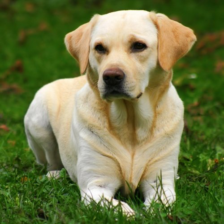

In [56]:
pets = ['American_water_spaniel_00648.jpg' , 'Brittany_02625.jpg', 
        'Curly-coated_retriever_03896.jpg', 'Labrador_retriever_06449.jpg',
        'Labrador_retriever_06455.jpg', 'Labrador_retriever_06457.jpg',
        'Welsh_springer_spanel_08203.jpg']

dog_link = '/home/workspace/dog-project/images/Labrador_retriever_06457.jpg'

img = load_img(dog_link, 
               target_size=(224, 224)) #size of the image
img

In [57]:
#transforming this into an Array
img_array = img_to_array(img)
print('shape of the image 3D RGB Array:', img_array.shape)

#turning this a Tensor
d4_tensor = np.expand_dims(img_array, 
                           axis=0)
print('shape of the image 4D Tensor:', d4_tensor.shape)

shape of the image 3D RGB Array: (224, 224, 3)
shape of the image 4D Tensor: (1, 224, 224, 3)


---

#### Test Area

Fix these errors:


- `TypeError: src is not a numpy array, neither a scalar` $\leftarrow$ not in this way!


- `ValueError: Error when checking : expected conv2d_6_input to have shape (None, 1, 1, 2048) but got array with shape (1, 224, 224, 3)` $\leftarrow$ neither in this way!


In [58]:
#gray = cv2.cvtColor(img_array, 
#                    cv2.COLOR_BGR2GRAY)
#gray.shape

In [59]:
#img1 = prep(img).unsqueeze(0)
#img1.shape

---

#### 3. Function for predicting the dog breed

It needs `path_to_tensor` function to run!

My function is here, but I have some more things to do...

In [60]:
#########1#########2#########3#########4#########5#########6#########7#########8
def resnet50_dog_pred(model,
                      img_path,
                      verbose=False):
    '''
    This function takes a image by a path and returns a prediction, given a pre
    trained model and his respective Bottleneck.

    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!

    
    Inputs:
    - model (mandatory) - my pre-trained model goes here
    - img_path (mandatory) - the image path for my prediction
    - verbose (optional) - if you want some verbosity under processing
      (default=False)
    
    Output:
    - best guess for the image at the path
    '''
    if verbose:
        print('###function ResNet 50 dog predictor started')

    start = time()
        
    #First, defining my tensor
    my_tensor = path_to_tensor(img_path)
    
    #Second, extractiong Resnet50 Bottleneck
    b_neck = extract_Resnet50(my_tensor)

    #obtaining my prediction, by running my pre-trained model
    my_pred_vect = model.predict(b_neck)

    #I want only my best prediction, so
    best_pred = dog_names[np.argmax(my_pred_vect)]
    
    end = time()

    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))
    
    return best_pred

And in this **first** test it looks OK:

In [61]:
dog_link = '/home/workspace/dog-project/images/Labrador_retriever_06457.jpg'

resnet50_dog_pred(
    model=trained_model,
    img_path=dog_link,
    verbose=True
)

###function ResNet 50 dog predictor started
elapsed time: 5.9464s


'ages/train/096.Labrador_retriever'

Let´s try it with **my own** pic:
    
- And OK... I am a **Silky Terrier**!

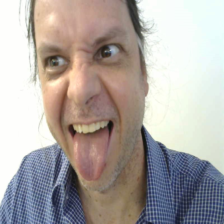

In [62]:
#source: picture of myself looking as a dog
#other pics from Wikipedia, reshaped for 224x224 using Gimp
#Albert Einstein (Physic, Scientist)
#Roland Macdonalds (Character, Promoter)
#Fofao (a man dressed as a dog, Child TV Program - 80´s - Brazillian Open Channel)
#Werewolf (terror movie, 1996)
#########1#########2#########3#########4#########5#########6#########7#########8
some_pics = ['Albert_Einstein_Wiki.jpg' , 'Roland_Wiki.jpg', 
        'SpockNimoy_Wiki.jpg', 'MyPicAsDog.jpg',
        'Fofao_Wiki.jpg', 'Werewolf_Wiki.jpg']

pic_link = '/home/workspace/dog-project/images/MyPicAsDog.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image
img

In [63]:
dog_link = '/home/workspace/dog-project/images/MyPicAsDog.jpg'

resnet50_dog_pred(
    model=trained_model,
    img_path=dog_link,
    verbose=True
)

###function ResNet 50 dog predictor started
elapsed time: 6.1388s


'ages/train/050.Chinese_shar-pei'

**Final Commentary on Step 5**

OK, I could fix my function and test for a **Labrador**. But looking at **Keras** documentation, I noticed that I have a **LOT** to learn!

That was my first experience with Perceptrons and for a first step, it´s OK. But I will **really** need a deeper course if I want to go into it...

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### Write your Algorithm

**First**, testing the two main functions

**Human** detector recognized from a list of (supposed) humans as a **human**:

- Albert Einstein

- Roland Macdonalds

- Mr Spock

- Fofao

And **didn´t** recognize:

- myself (OMG!)

- Werewolf

*There is a **problem** here, as my own picture was **not** accepted as **Human**! Perhaps the explanation is that my pic was so distort by my webcam, and silly adjustments, that the algorithm couldn´t recoginize it so well...*

In [64]:
some_pics = ['Albert_Einstein_Wiki.jpg' , 'Roland_Wiki.jpg', 
        'SpockNimoy_Wiki.jpg', 'MyPicAsDog.jpg',
        'Fofao_Wiki.jpg', 'Werewolf_Wiki.jpg']

for one_pic in some_pics:

    pic_link = '/home/workspace/dog-project/images/' + one_pic

    answ1 = face_detector(
        img_path=pic_link,
        verbose=True)

###function face detector started
*image: /home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04705s
###function face detector started
*image: /home/workspace/dog-project/images/Roland_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.03977s
###function face detector started
*image: /home/workspace/dog-project/images/SpockNimoy_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04178s
###function face detector started
*image: /home/workspace/dog-project/images/MyPicAsDog.jpg
*number of faces detected:0, returning False
processing time: 0.1945s
###function face detector started
*image: /home/workspace/dog-project/images/Fofao_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04286s
###function face detector started
*image: /home/workspace/dog-project/images/Werewolf_Wiki.jpg
*number of faces detected:0, returning False
processing time: 0.04129s


In [65]:
answ1[0]

False

**Dog** detector recognized from a list of **humans** as a dog:

- no one in the list (that´s fine!)

In [66]:
some_pics = ['Albert_Einstein_Wiki.jpg' , 'Roland_Wiki.jpg', 
        'SpockNimoy_Wiki.jpg', 'MyPicAsDog.jpg',
        'Fofao_Wiki.jpg', 'Werewolf_Wiki.jpg']

for one_pic in some_pics:

    pic_link = '/home/workspace/dog-project/images/' + one_pic

    answ2 = dog_detector(
        img_path=pic_link,
        verbose=True)

###function dog detector started
*image: /home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg
*if a dog was detect: False
processing time: 0.04611s
###function dog detector started
*image: /home/workspace/dog-project/images/Roland_Wiki.jpg
*if a dog was detect: False
processing time: 0.04505s
###function dog detector started
*image: /home/workspace/dog-project/images/SpockNimoy_Wiki.jpg
*if a dog was detect: False
processing time: 0.04511s
###function dog detector started
*image: /home/workspace/dog-project/images/MyPicAsDog.jpg
*if a dog was detect: False
processing time: 0.05322s
###function dog detector started
*image: /home/workspace/dog-project/images/Fofao_Wiki.jpg
*if a dog was detect: False
processing time: 0.04563s
###function dog detector started
*image: /home/workspace/dog-project/images/Werewolf_Wiki.jpg
*if a dog was detect: False
processing time: 0.04466s


In [67]:
answ2

False

In [68]:
some_pets = ['American_water_spaniel_00648.jpg' , 'Brittany_02625.jpg', 
             'Curly-coated_retriever_03896.jpg', 'Labrador_retriever_06449.jpg',
             'Labrador_retriever_06455.jpg', 'Labrador_retriever_06457.jpg']

for one_pet in some_pets:

    pic_link = '/home/workspace/dog-project/images/' + one_pet

    dog_detector(
        img_path=pic_link,
        verbose=True)

###function dog detector started
*image: /home/workspace/dog-project/images/American_water_spaniel_00648.jpg
*if a dog was detect: True
processing time: 0.04444s
###function dog detector started
*image: /home/workspace/dog-project/images/Brittany_02625.jpg
*if a dog was detect: True
processing time: 0.04693s
###function dog detector started
*image: /home/workspace/dog-project/images/Curly-coated_retriever_03896.jpg
*if a dog was detect: True
processing time: 0.04573s
###function dog detector started
*image: /home/workspace/dog-project/images/Labrador_retriever_06449.jpg
*if a dog was detect: True
processing time: 0.04684s
###function dog detector started
*image: /home/workspace/dog-project/images/Labrador_retriever_06455.jpg
*if a dog was detect: True
processing time: 0.04673s
###function dog detector started
*image: /home/workspace/dog-project/images/Labrador_retriever_06457.jpg
*if a dog was detect: True
processing time: 0.04553s


**Second** creating the main function:

In [69]:
#########1#########2#########3#########4#########5#########6#########7#########8
def Image_checker(model,
                  img_path,
                  distort=False,
                  decompress=False,
                  verbose=False):
    '''
    This function takes an image path and checks if it seems as a picture of a 
    dog, or of a human, or neither than any of these categories.
    
    Special note: this function is STRONGLY based on Udacity notebook for Dog
    Breed Classifications, for completing the Capstone Project for Data Scientist
    course. It may be used for educational purposes only!
    
    Inputs:
    - model (mandatory) - the model for classification of breed, if is a human
    - img_path (mandatory) - string of characters for the image path
    - distort (optional) - if you want to emulate the effect of resizing a (3x4)
      format image - (Boolean, default=False)
    - decompress (optional) - it is the opposite of distort, if you want to
      correct the effect of resizing a (3x4) - (Boolean, default=False)
      *please don´t set both, so if you set "decompress=True", don´t set
       "correct=True", as it don´t make sense!
      format image - (Boolean, default=False)      
    - verbose (optional) - if you want some verbosity under processing
      (default=False)
      
    Output:
    - some text about 
      1-if you are recognized as a human
      2-as a dog
      3-neither
      4-if as a human, the dog breed that is more likely at our trained
        classifier
    - if everything runs well, returns True
    '''
    if verbose:
        print('###function image checker started')

    start = time()
    
    if distort and decompress:
        raise Exception('bad arguments! you cannot use both distort and decompress')

    answ1 = face_detector(
                img_path=img_path,
                distort=distort,
                decompress=decompress,
                verbose=verbose
    )
    answ2 = dog_detector(
                img_path=img_path,
                distort=distort,
                decompress=decompress,
                verbose=verbose
    )
    human = answ1[0]
    dog = answ2
  
    if human:
        print('I detected something that looks like a human')
        
        breed = resnet50_dog_pred(
            model=model,
            img_path=img_path,
            verbose=verbose
        )
        print('...and if you were a dog, you breed should be', breed[15:])
        
        if dog: #this means a bad classification
            print('I also think in someway that it looks like a dog')
            Print('...so please check this image!')
            
    elif dog:
        print('I detected something that looks like a dog')
        
        if human: #this means a bad classification
            print('I also think in someway that it looks like a human')
            print('...so please check this image!')

    else:
        print('Sorry, nothing detected!')
        print('...so please check this image!')
                    
    end = time()

    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))
        
    return True

---

### Resizing images using OpenCV

1. distorting opperation

- documentation and example code [here](https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/)

- the idea is changing some of the tested images, distorting them

  - we can see if our pre-trained machine can deal with **distorted** images
  
  - it is not an uncommon problem, as our Perceptron takes 224x224 images, and normally images came in proportions more likely as photographic 3x4 size, for example (as 800x600)
  
  - this is not a problem about only **resize**, as we are trying to recognize images with different proportions, not **cropping** them!

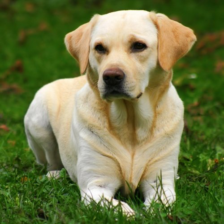

In [70]:
dog_link = '/home/workspace/dog-project/images/Labrador_retriever_06457.jpg'

img = load_img(dog_link, 
               target_size=(224, 224))
img

If w is **224**, h must be:

- w/h ratio is:

*The idea here is quite simple, I will just reprocess the image, increasing the **height** of the image, creating a distortion effect similar of compressing it **horizontally**, then I will crop it for returning it into **224x224** square format.

working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)


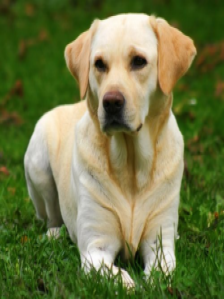

In [71]:
h1 = 600
w1 = 800

h2 = 224
w2 = 224

print('working on pre-existing image')

new_h2 = round(224 * (800 / 600)) 
print('*new height for emulating a 800x600 compression:', new_h2)

#transforming this into an Array
img_array = img_to_array(img)
print('*shape of the image 3D Tensor:', img_array.shape)

#img_dim = (width, height)
img_dim = (224, new_h2)

#resized image as array
img_res = cv2.resize(img_array, 
                     img_dim, 
                     interpolation=cv2.INTER_AREA)

print('*new shape of the image 3D RGB Array:', img_res.shape)

dist_img = array_to_img(img_res)
dist_img

The OpenCV command for this opperation is **slicing**:

2. cropping opperation

- some tips and example code at [stack overflow](https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python)

#### Stategy

- all our images are originally **224x224**

- the idea is to emulate a **800x600** image, and then cropping back into **224x224**

If I do everything in a correct way, it will give me the effect of taking a originally **800x600** image format and then automatically distorting it to fit into a **224x224** format. Then try to recognize it use our Perceptron.

- it it could work with the new format, I can say at the documentation that you can do this opperation;

- if not, I will say that it only accepts **224x224** original formats to work, with no distortions.

From **Stack Overflow**:

"If we consider (0,0) as top left corner of image called im with left-to-right as x direction and top-to-bottom as y direction. and we have (x1,y1) as the top-left vertex and (x2,y2) as the bottom-right vertex of a rectangle region within that image, then:"

`roi = im[y1:y2, x1:x2]`

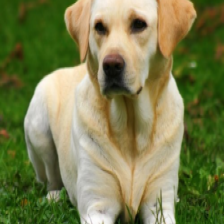

In [72]:
#img_dim = (x-width, y-height)
img_dim = (224, 299)

y_bottom = (new_h2 - 224) // 2

#using Numpy opperations
dist_array = np.asarray(dist_img)
crop_array = dist_array[y_bottom:224+y_bottom, 0:224]

crop_array.shape

prep_img = array_to_img(crop_array)
prep_img

My **Distort-a-pic** function:

In [73]:
#########1#########2#########3#########4#########5#########6#########7#########8
def emulate_svga_dist(image,
                      as_array=False,
                      verbose=False):
    '''
    This function takes a 224x224 Perceptron-sized image and applies a
    SVGA-emulated distortion into it.
    
    The idea is that a lot of images came from Webcams and other devices, that
    normally opperates (3x4-camera) proportions. One of the most usual of these
    formats is SVGA (800x600) images. Normally they tells us that Perceptrons
    are robust to slight distortions on the image. So, theoretically the only
    thing you need to do is just to resize this image to 224x244 and all is
    done!
    
    Well, I tried a recognition of my face. It was taken by a VGA Legitech
    webcam, in a well-illuminated office. And my Percetron couldn´t recognize
    me as a man.
    
    So, the idea is to take all these pics that we used to test our Perceptron
    and artificially distort them into a kind of distortion produced when I make
    a horizontal compression of the image.
    
    Inputs:
    - a normal (224x224) RGB .jpg image
    - verbose (optional) - if you want some verbosity under processing
      (default=False)

    Output:
    - an artificially distorted (224x224) RGB .jpg image
    '''
    if verbose:
        print('###function emulate SVGA image distortion (800x600)->(224x224) started')

    start = time()

    h1 = 600
    w1 = 800

    h2 = 224
    w2 = 224

    if verbose:
        print('*working on pre-existing image')

    new_h2 = round(224 * (800 / 600))
    
    if verbose:
        print('*new height for emulating a 800x600 compression:', new_h2)

    if as_array: #transforming this into an Array
        img_array = image #do nothing
    else:
        img_array = img_to_array(image)
    
    if verbose:
        print('*shape of the image 3D Tensor:', img_array.shape)

    #img_dim = (width, height)
    img_dim = (224, new_h2)

    #resized image as array
    img_res = cv2.resize(img_array, 
                         img_dim, 
                         interpolation=cv2.INTER_AREA)

    if verbose:
        print('*new shape of the image 3D RGB Array:', img_res.shape)

    dist_img = array_to_img(img_res)
    
    #img_dim = (x-width, y-height)
    img_dim = (224, 299)

    y_bottom = (new_h2 - 224) // 2

    #using Numpy opperations
    dist_array = np.asarray(dist_img)
    crop_array = dist_array[y_bottom:224+y_bottom, 0:224]

    if verbose:
        print('*new shape after cropping:', crop_array.shape)
    
    if as_array:
        prep_img = crop_array #give as array
    else:
        prep_img = array_to_img(crop_array)

    end = time()

    if verbose:
        print('elapsed time: {:.4f}s'.format(end-start))
    
    return prep_img

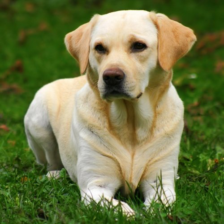

In [74]:
dog_link = '/home/workspace/dog-project/images/Labrador_retriever_06457.jpg'

img = load_img(dog_link, 
               target_size=(224, 224))
img

###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0065s


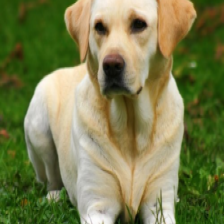

In [75]:
dist_img = emulate_svga_dist(image=img,
                             verbose=True)
dist_img

---

### Opposite function: Correct Image

#### A big problem to solve

- I have a SVGA image (800x600), in 3x4 (truly 4x3) format, and it was distorted (horizontal compression) to be feeded to our Perceptron;

- Just suppose that I don´t have the original one anymore. And I tried make a face/dog recognition on it and the aswer was: "no face human, neither a dog recognized in this picture";

- This is a terrible problem. Suppose that I have **thousands** of these images, an I cannot just e-mail people, asking for a new image!

Take a look into this image. I can easily recognize a kind of a guy (in this case, is myself!), trying to pass as a dog...

- for my brain, it is quite **imperceptible** the distortion. But for our Perceptron, is **not**;

- let´s try to correct it creating a new function

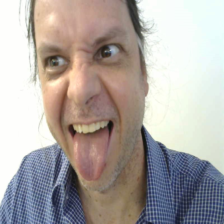

In [76]:
pic2_link = '/home/workspace/dog-project/images/MyPicAsDog.jpg'

img2 = load_img(pic2_link, 
               target_size=(224, 224))
img2

In [77]:
#########1#########2#########3#########4#########5#########6#########7#########8
def decompress_svga_img(image,
                        as_array=False,
                        verbose=False):
    h1 = 600
    w1 = 800

    h2 = 224
    w2 = 224

    if verbose:
        print('*working on pre-existing image')

    #now, I need a new width    
    new_w2 = round(224 * (800 / 600))
    
    if verbose:
        print('*new width for emulating a 800x600 decompression:', new_w2)
        
    if as_array: #transforming this into an Array
        img_array = image #do nothing
    else:
        img_array = img_to_array(image)
    
    if verbose:
        print('*shape of the image 3D Tensor:', img_array.shape)

    #img_dim = (width, height)
    img_dim = (new_w2, 224)

    #resized image as array
    img_res = cv2.resize(img_array, 
                         img_dim, 
                         interpolation=cv2.INTER_AREA)

    if verbose:
        print('*new shape of the image 3D RGB Array:', img_res.shape)

    dist_img = array_to_img(img_res)
    
    #img_dim = (x-width, y-height)
    img_dim = (299, 224)

    x_bottom = (new_w2 - 224) // 2

    #using Numpy opperations
    dist_array = np.asarray(dist_img)
    crop_array = dist_array[0:224, x_bottom:224+x_bottom,]

    if verbose:
        print('*new shape after cropping:', crop_array.shape)
        
    if as_array:
        prep_img = crop_array
    else:
        prep_img = array_to_img(crop_array)
    
    return prep_img

Testing our **decompressing** function:

- well, it is not a **perfect** strategy, as occurred some pixels loss in x-axis;

- and the **expanding algorithm** consumes a bit of the image quality.

In hope that the **gains** compensate the **losses**, in terms of Accuracy when this new-brand-corrected-image is feeded into our Perceptron... 

*working on pre-existing image
*new width for emulating a 800x600 decompression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (224, 299, 3)
*new shape after cropping: (224, 224, 3)


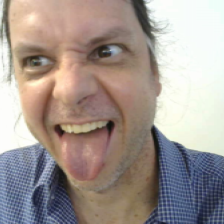

In [78]:
undist_img = decompress_svga_img(image=img2,
                                 verbose=True)
undist_img

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [79]:
some_pics = ['Albert_Einstein_Wiki.jpg' , 'Roland_Wiki.jpg', 
        'SpockNimoy_Wiki.jpg', 'MyPicAsDog.jpg',
        'Fofao_Wiki.jpg', 'Werewolf_Wiki.jpg']

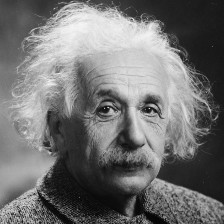

In [80]:
pic_link = '/home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image
img

In [81]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    verbose=True
)

###function image checker started
###function face detector started
*image: /home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04215s
###function dog detector started
*image: /home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg
*if a dog was detect: False
processing time: 0.04162s
I detected something that looks like a human
###function ResNet 50 dog predictor started
elapsed time: 6.5669s
...and if you were a dog, you breed should be Cocker_spaniel
elapsed time: 6.6517s


True

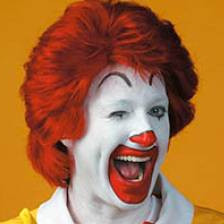

In [82]:
pic_link = '/home/workspace/dog-project/images/Roland_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image
img

In [83]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    verbose=True
)

###function image checker started
###function face detector started
*image: /home/workspace/dog-project/images/Roland_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04171s
###function dog detector started
*image: /home/workspace/dog-project/images/Roland_Wiki.jpg
*if a dog was detect: False
processing time: 0.042s
I detected something that looks like a human
###function ResNet 50 dog predictor started
elapsed time: 6.9734s
...and if you were a dog, you breed should be Norwegian_lundehund
elapsed time: 7.0579s


True

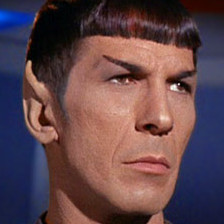

In [84]:
pic_link = '/home/workspace/dog-project/images/SpockNimoy_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image
img

In [85]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    verbose=True
)

###function image checker started
###function face detector started
*image: /home/workspace/dog-project/images/SpockNimoy_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04555s
###function dog detector started
*image: /home/workspace/dog-project/images/SpockNimoy_Wiki.jpg
*if a dog was detect: False
processing time: 0.04156s
I detected something that looks like a human
###function ResNet 50 dog predictor started
elapsed time: 7.4759s
...and if you were a dog, you breed should be Bullmastiff
elapsed time: 7.5641s


True

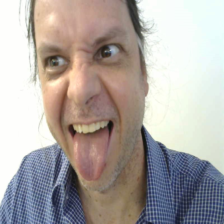

In [86]:
pic_link = '/home/workspace/dog-project/images/MyPicAsDog.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image
img

In [87]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    verbose=True
)

###function image checker started
###function face detector started
*image: /home/workspace/dog-project/images/MyPicAsDog.jpg
*number of faces detected:0, returning False
processing time: 0.1961s
###function dog detector started
*image: /home/workspace/dog-project/images/MyPicAsDog.jpg
*if a dog was detect: False
processing time: 0.05054s
Sorry, nothing detected!
...so please check this image!
elapsed time: 0.2479s


True

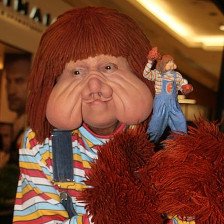

In [88]:
pic_link = '/home/workspace/dog-project/images/Fofao_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image
img

In [89]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    verbose=True
)

###function image checker started
###function face detector started
*image: /home/workspace/dog-project/images/Fofao_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04131s
###function dog detector started
*image: /home/workspace/dog-project/images/Fofao_Wiki.jpg
*if a dog was detect: False
processing time: 0.04239s
I detected something that looks like a human
###function ResNet 50 dog predictor started
elapsed time: 7.4366s
...and if you were a dog, you breed should be Brussels_griffon
elapsed time: 7.5214s


True

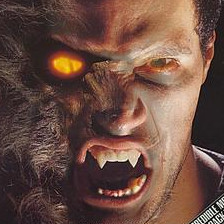

In [90]:
pic_link = '/home/workspace/dog-project/images/Werewolf_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image
img

In [91]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    verbose=True
)

###function image checker started
###function face detector started
*image: /home/workspace/dog-project/images/Werewolf_Wiki.jpg
*number of faces detected:0, returning False
processing time: 0.0439s
###function dog detector started
*image: /home/workspace/dog-project/images/Werewolf_Wiki.jpg
*if a dog was detect: False
processing time: 0.04288s
Sorry, nothing detected!
...so please check this image!
elapsed time: 0.0872s


True

Now, testing for **dog images**:

- and none **False Positive** or **False Negative**

In [92]:
some_pets = ['American_water_spaniel_00648.jpg' , 'Brittany_02625.jpg', 
             'Curly-coated_retriever_03896.jpg', 'Labrador_retriever_06449.jpg',
             'Labrador_retriever_06455.jpg', 'Labrador_retriever_06457.jpg']

for one_pet in some_pets:
    print()
    print('checking:', one_pet)

    pic_link = '/home/workspace/dog-project/images/' + one_pet

    Image_checker(
        model=trained_model,
        img_path=pic_link,
        verbose=True)


checking: American_water_spaniel_00648.jpg
###function image checker started
###function face detector started
*image: /home/workspace/dog-project/images/American_water_spaniel_00648.jpg
*number of faces detected:0, returning False
processing time: 0.1066s
###function dog detector started
*image: /home/workspace/dog-project/images/American_water_spaniel_00648.jpg
*if a dog was detect: True
processing time: 0.0452s
I detected something that looks like a dog
elapsed time: 0.1527s

checking: Brittany_02625.jpg
###function image checker started
###function face detector started
*image: /home/workspace/dog-project/images/Brittany_02625.jpg
*number of faces detected:0, returning False
processing time: 0.2036s
###function dog detector started
*image: /home/workspace/dog-project/images/Brittany_02625.jpg
*if a dog was detect: True
processing time: 0.04863s
I detected something that looks like a dog
elapsed time: 0.2525s

checking: Curly-coated_retriever_03896.jpg
###function image checker sta

---

### Extra - Using the SVGA Compressor / Decompressor

Let´s work with Einstein:

- artificially generating an **compressed** Einstein

###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0073s


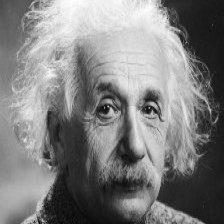

In [93]:
pic_link = '/home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image

dist_img = emulate_svga_dist(image=img,
                             verbose=True)
dist_img

In [94]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    distort=True,
    verbose=True
)

###function image checker started
###function face detector started
*applying (800x600) distortion emulated
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0029s
*image: /home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04769s
###function dog detector started
*image: /home/workspace/dog-project/images/Albert_Einstein_Wiki.jpg
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0055s
*if a dog was detect: F

True

###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0065s


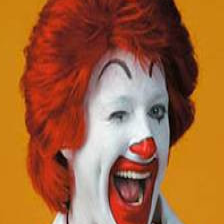

In [95]:
pic_link = '/home/workspace/dog-project/images/Roland_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image

dist_img = emulate_svga_dist(image=img,
                             verbose=True)
dist_img

In [96]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    distort=True,
    verbose=True
)

###function image checker started
###function face detector started
*applying (800x600) distortion emulated
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0025s
*image: /home/workspace/dog-project/images/Roland_Wiki.jpg
*number of faces detected:2, returning True
processing time: 0.04628s
###function dog detector started
*image: /home/workspace/dog-project/images/Roland_Wiki.jpg
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0051s
*if a dog was detect: False
processing ti

True

###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0074s


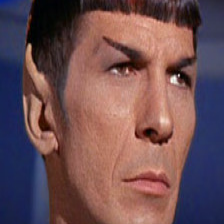

In [97]:
pic_link = '/home/workspace/dog-project/images/SpockNimoy_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image

dist_img = emulate_svga_dist(image=img,
                             verbose=True)
dist_img

In [98]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    distort=True,
    verbose=True
)

###function image checker started
###function face detector started
*applying (800x600) distortion emulated
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0024s
*image: /home/workspace/dog-project/images/SpockNimoy_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04597s
###function dog detector started
*image: /home/workspace/dog-project/images/SpockNimoy_Wiki.jpg
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0051s
*if a dog was detect: False
proce

True

Now checking for this image, just the **opposite**, to **decompress**:

- it was an original 800x600 SVGA, resized and compressed for **square** proportions, now I am testing my brand new (experimental) decompress SVGA function!;

- and, **not a big deal**, the Perceptrion takes this (und)distorted image, and it remains incapable to interpret it a human!

*working on pre-existing image
*new width for emulating a 800x600 decompression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (224, 299, 3)
*new shape after cropping: (224, 224, 3)


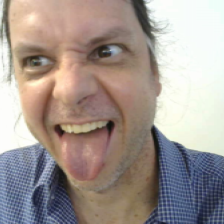

In [99]:
pic_link = '/home/workspace/dog-project/images/MyPicAsDog.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image

undist_img = decompress_svga_img(image=img,
                                 verbose=True)
undist_img

In [100]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    decompress=True,
    verbose=True
)

###function image checker started
###function face detector started
*applying (800x600) distortion emulated
*working on pre-existing image
*new width for emulating a 800x600 decompression: 299
*shape of the image 3D Tensor: (600, 800, 3)
*new shape of the image 3D RGB Array: (224, 299, 3)
*new shape after cropping: (224, 224, 3)
*image: /home/workspace/dog-project/images/MyPicAsDog.jpg
*number of faces detected:0, returning False
processing time: 0.05313s
###function dog detector started
*image: /home/workspace/dog-project/images/MyPicAsDog.jpg
*if a dog was detect: False
processing time: 0.0581s
Sorry, nothing detected!
...so please check this image!
elapsed time: 0.1115s


True

###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0072s


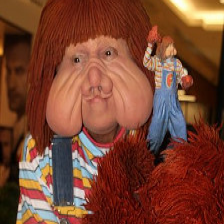

In [101]:
pic_link = '/home/workspace/dog-project/images/Fofao_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image

dist_img = emulate_svga_dist(image=img,
                             verbose=True)
dist_img

In [102]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    distort=True,
    verbose=True
)

###function image checker started
###function face detector started
*applying (800x600) distortion emulated
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0027s
*image: /home/workspace/dog-project/images/Fofao_Wiki.jpg
*number of faces detected:1, returning True
processing time: 0.04639s
###function dog detector started
*image: /home/workspace/dog-project/images/Fofao_Wiki.jpg
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0056s
*if a dog was detect: False
processing time

True

###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0068s


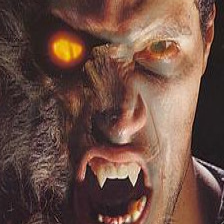

In [103]:
pic_link = '/home/workspace/dog-project/images/Werewolf_Wiki.jpg'

img = load_img(pic_link, 
               target_size=(224, 224)) #size of the image

dist_img = emulate_svga_dist(image=img,
                             verbose=True)
dist_img

In [104]:
Image_checker(
    model=trained_model,
    img_path=pic_link,
    distort=True,
    verbose=True
)

###function image checker started
###function face detector started
*applying (800x600) distortion emulated
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0027s
*image: /home/workspace/dog-project/images/Werewolf_Wiki.jpg
*number of faces detected:0, returning False
processing time: 0.04994s
###function dog detector started
*image: /home/workspace/dog-project/images/Werewolf_Wiki.jpg
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0058s
*if a dog was detect: False
processi

True

Now, testing distortion for **dog images**:

- and none **False Positive** or **False Negative**

In [105]:
some_pets = ['American_water_spaniel_00648.jpg' , 'Brittany_02625.jpg', 
             'Curly-coated_retriever_03896.jpg', 'Labrador_retriever_06449.jpg',
             'Labrador_retriever_06455.jpg', 'Labrador_retriever_06457.jpg']

for one_pet in some_pets:
    print()
    print('checking:', one_pet)

    pic_link = '/home/workspace/dog-project/images/' + one_pet

    Image_checker(
        model=trained_model,
        img_path=pic_link,
        distort=True,
        verbose=True)


checking: American_water_spaniel_00648.jpg
###function image checker started
###function face detector started
*applying (800x600) distortion emulated
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (375, 500, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping: (224, 224, 3)
elapsed time: 0.0047s
*image: /home/workspace/dog-project/images/American_water_spaniel_00648.jpg
*number of faces detected:0, returning False
processing time: 0.0514s
###function dog detector started
*image: /home/workspace/dog-project/images/American_water_spaniel_00648.jpg
###function emulate SVGA image distortion (800x600)->(224x224) started
*working on pre-existing image
*new height for emulating a 800x600 compression: 299
*shape of the image 3D Tensor: (224, 224, 3)
*new shape of the image 3D RGB Array: (299, 224, 3)
*new shape after cropping:

---

## Test Area

In [106]:
raise Exception('Test Area')

Exception: Test Area

In [ ]:
pic_link = '/home/workspace/dog-project/images/Werewolf_Wiki.jpg'

img = preprocess_input(path_to_tensor(pic_link))

img = load_img(pic_link, 
               target_size=(224, 224))

dist_img = emulate_svga_dist(image=img,
                             verbose=True)

x = img_to_array(img) #3 channels for colors
    
d4_tensor = np.expand_dims(x, 
                           axis=0) #tensor dims

d4_tensor.shape